# Spam / ham email classifier 

Data set used: https://www.kaggle.com/veleon/ham-and-spam-dataset

In [1]:
import os
from email import message_from_bytes, policy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def import_files(file_path):
    """ returns a list of parsed email objects """

    msgs = []

    for fn in os.listdir(file_path):
        with open(os.path.join(file_path, fn), mode="rb") as f:
            msg = message_from_bytes(f.read(), policy=policy.default)

            msgs.append(msg)

    return msgs


def email_content_type(message):
    """ determine multipart files """

    if isinstance(message, str):
        return message

    payload = message.get_payload()

    if isinstance(payload, list):
        return "multipart({})".format(
            ", ".join([email_content_type(_email) for _email in payload])
        )
    else:
        return message.get_content_type()


def html_to_text(html_email):
    try:
        soup = BeautifulSoup(html_email.get_content(), features="html.parser")

        return soup.get_text().replace("\n\n", "").replace("\n", " ")
    except LookupError:
        return ""


def clean_email(message):
    """ email object -> text """

    for part in message.walk():
        part_content_type = part.get_content_type()

        if part_content_type not in ["text/plain", "text/html"]:
            continue

        try:
            part_content = part.get_content()
        except Exception:
            part_content = str(part.get_payload())

        if part_content_type == "text/plain":
            return part_content
        else:
            return html_to_text(part)


def make_data_set(files):
    data_set = []

    for f in files:
        data_set.append(clean_email(f))

    return data_set

# input data 
ham_path = "./input/ham"
spam_path = "./input/spam"

ham_files = import_files(ham_path)
spam_files = import_files(spam_path)

# temp solution for removing pesky `None` objects
ham_data_set = [d for d in make_data_set(ham_files) if d is not None]
spam_data_set = [d for d in make_data_set(spam_files) if d is not None]

print(f"Ham count: {len(ham_data_set)}\nSpam count: {len(spam_data_set)}")

Ham count: 2551
Spam count: 500


In [3]:
# all data 
X = ham_data_set + spam_data_set
# labels (0 => ham, 1 => spam)
y = [0] * len(ham_data_set) + [1] * len(spam_data_set)

# split all data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=0)

In [4]:
# naive bayes

# classifier = make_pipeline(
#     TfidfVectorizer(min_df=5, ngram_range=(2,5)),
#     MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
# )

In [5]:
# SVM

classifier = make_pipeline(
    TfidfVectorizer(min_df=5, ngram_range=(2,5)),
    SVC(C=100, gamma= 0.1, kernel='rbf'),
)

In [10]:
%%time

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

CPU times: user 9.43 s, sys: 225 ms, total: 9.65 s
Wall time: 9.67 s


In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       644
           1       0.97      0.97      0.97       119

    accuracy                           0.99       763
   macro avg       0.98      0.98      0.98       763
weighted avg       0.99      0.99      0.99       763



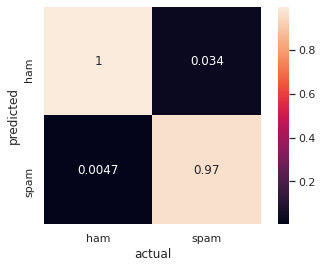

In [11]:
%matplotlib inline

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, index=["ham", "spam"], columns=["ham", "spam"])
conf_mat = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

sns.set()
sns.heatmap(conf_mat.T, square=True, annot=True)

plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

In [12]:
df_data = []

for i, d in enumerate(X_test):
    df_data.append([d, "spam" if y_pred[i] == 1 else "ham"])

pd.DataFrame(df_data, columns=["content", "prediction"]).query("prediction == 'spam'")

,content,prediction
2,"Me and my friends have this brand new idea, a ...",spam
4,Private Label Reseller Hosting Plans S...,spam
6,這是委託由專業廣告公司代發勿直接回信無法接收 呦 \r 這是委託由專業廣告公司代發勿直接回信...,spam
7,::FREE MORTGAGE QUOTE::To be removed from this...,spam
9,\nPUBLIC ANNOUNCEMENT:\n\nThe new domain names...,spam
...,...,...
719,HELLO...By reading the short Summary just belo...,spam
728,\n Do You Want To Teach and G...,spam
739,SMSTR lilhwmuxvrsyqcwjhvttxw Degerli SMSTR ku...,spam
754,Help wanted. We are a 14 year old fortune 500...,spam
